In [2]:
import os
import gc
import shutil
if os.getenv("COLAB_RELEASE_TAG"):
    # Colab
    print("RUNNING ON COLAB")
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_DIR = "/content/drive/MyDrive/GaggleSignLang/asl-signs"
    WORKING_DIR = "/content/asl-work"
    ARCHIVE_DIR = "/content/drive/MyDrive/GaggleSignLang"
    MODEL_DIR = "/content/drive/MyDrive/GaggleSignLang/models"
elif os.environ.get('KAGGLE_KERNEL_RUN_TYPE'):
    # KAGGLE
    print("RUNNING ON KAGGLE")
    BASE_DIR = "/kaggle/input/asl-signs"
    WORKING_DIR = "/kaggle/working"
    ARCHIVE_DIR = "/kaggle/working"
    MODEL_DIR  = "/kaggle/working"
else: 
    # Jupiter  MacOS
    print("RUNING JUPITER LOCAL")
    BASE_DIR = "/Users/johnhanratty/ASLtest/asl-signs"  #"/Users/johnhanratty/ASLtest/asl-signs"
    WORKING_DIR = "/Users/johnhanratty/ASLtest"
    ARCHIVE_DIR = "/Users/johnhanratty/ASLtest"
    MODEL_DIR = "/Users/johnhanratty/ASLtest/models"

import time

import json
from tqdm import tqdm
import numpy as np
import pandas as pd
import pickle
from random import seed, sample

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings(action='ignore')

LANDMARK_FILES_DIR = f'{BASE_DIR}/train_landmark_files'
TRAIN_FILE = f"{BASE_DIR}/train.csv"

FRAMES_OUT = 96 # 16
PCA_COMPONENTS = 120
RECALCULATE_PCA = False
PTS_IN_FRAME = 345
DIMC = [0,1,2]
DIMS = len(DIMC)
WORKERS = 0   # dataoader work var  0 for MAC, 4 for online

!pip install tsai --quiet
from tsai.all import *
from fastai.callback.tracker import EarlyStoppingCallback


my_setup()


print('done')

RUNNING ON COLAB
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
os              : Linux-5.15.107+-x86_64-with-glibc2.31
python          : 3.10.11
tsai            : 0.3.6
fastai          : 2.7.12
fastcore        : 1.5.29
torch           : 2.0.0+cu118
device          : 1 gpu (['Tesla V100-SXM2-16GB'])
cpu cores       : 2
threads per cpu : 2
RAM             : 25.45 GB
GPU memory      : [16.0] GB
done


In [ ]:
ROWS_PER_FRAME = 543  # number of landmarks per frame

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [ ]:
# CNN TORCH FEATUREGEN MODEL 
ROWS_PER_FRAME = 543  # combined face, lefth, pose, righth
PR_PTS = [40, 44, 48, 52, 56, 60, 43, 46, 50, 54, 58]
SC_PTS = [40, 98, 102, 106, 110, 114, 97, 102, 106, 110, 114]
PO_PTS = [60, 73, 80, 81, 76, 77, 68, 69, 70, 71, 75, 74]
LI_PTS = [5, 0, 4, 8, 12, 16, 20, 24, 28, 32, 36]
PR_LEN = len(PR_PTS) * DIMS * 5  # 5 = number of aggregations e.g. max,min
SC_LEN = len(SC_PTS) * DIMS * 5
PO_LEN = len(PO_PTS) * DIMS * 5
LI_LEN = len(LI_PTS) * DIMS * 5
CNN_FEAT_LEN = PR_LEN + SC_LEN + PO_LEN + LI_LEN 

print("Feature Len", CNN_FEAT_LEN, PR_LEN, SC_LEN, PO_LEN, LI_LEN)

# FILTER FEATURES IN EACH FRAME  - FACE, POSE & HANDs
class FeatureGen(nn.Module):
    def __init__(self):
        super(FeatureGen, self).__init__()
        print(MODEL_DIR)
        # NOTE: need to incorporate {MODEL_DIR}/modelPCA_{PCA_COMPONENTS}.pkl" into __init__
        with open(f"{MODEL_DIR}/PCAmod_64_90.pkl", 'rb') as handle:
            self.pca_X = pickle.load(handle)
        
    
    def forward(self, x):
        x = torch.tensor(x)
        
        # FILTER TO SPECIFIED FRAMES (FRAMES_OUT)
        seed(24)
        n_frames = x.size()[0]
        # Trim to # of frames to FRAMES_OUT
        if n_frames > FRAMES_OUT:
            idx = sorted((sample(range(0, n_frames), FRAMES_OUT)))
            x=x[idx]
        n_frames = x.size()[0]
        # FLATTENING ROWS BY TYPE and CONCATENATING TO ONE ROW PER FRAME 3D (XYZ)
        # INPUT NUMPY, TORCH OUTPUT

        # The Video contains n_frames each containing exactly ROWS_PER_FRAME (543)frames.
        # The frames in each are in order of feature type.
        # The rows conain x, y, z for a feature
        #   Video Format = [n_frames][543 frames][3 xyz coordinates]
        
        # Create views by data type (e.g. one point on hand) 
        # by selecting rows for each frame
        # face_x = x[:,:468,:].contiguous().view(-1, 468*3)
        lips_idx = [61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 291, 78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 308, 95, 88, 178, 87, 14, 317, 402, 318, 324, 146, 91, 181, 84, 17, 314, 405, 321, 375]
        lips_x = x[:, lips_idx,:].contiguous().view(-1, len(lips_idx)*3)
        lefth_x = x[:,468:489,:].contiguous().view(-1, 21*3)
        pose_x = x[:,489:522,:].contiguous().view(-1, 33*3)
        righth_x = x[:,522:,:].contiguous().view(-1, 21*3)

        # Check for primary hand and if left hand swap and rotate hands
        if torch.isnan(lefth_x).sum() < torch.isnan(righth_x).sum():
            prime_x = lefth_x
            second_x = righth_x
        else:
            prime_x = righth_x.reshape(righth_x.size()[0], -1, DIMS)
            prime_x[:,:,0] = torch.from_numpy(np.subtract(np.nanmax(prime_x[:,:,0].numpy(), axis=1).reshape(-1,1),
                                    prime_x[:, :, 0].numpy()))
            prime_x = prime_x.reshape(prime_x.size()[0],-1)
            
            second_x = lefth_x.reshape(lefth_x.size()[0], -1, DIMS)
            second_x[:,:,0] = torch.from_numpy(np.subtract(np.nanmax(second_x[:,:,0].numpy(), axis=1).reshape(-1,1),
                                          second_x[:, :, 0].numpy()))
            second_x = second_x.reshape(second_x.size()[0],-1)
            
        
        # create video withfixed number of frames (FRAMES_OUT)
        # initialize with NoN so later operations can ignore them (e.g. nanmean()) 
        xfeat = torch.full([FRAMES_OUT, PTS_IN_FRAME], np.nan)
        
        # center frames
        offset = (FRAMES_OUT - n_frames) // 2  # center frames in output data in each frame in video
        
        # flatten types into one row per frame
        xfeat[offset:n_frames+offset,:] = torch.cat([lips_x, prime_x, pose_x, second_x], axis=1)  # concatenate types               
        
        ########UNTESTED IN THIS SCRIPT ########### 
        # NOTE: need to incorporate {MODEL_DIR}/modelPCA_{PCA_COMPONENTS}.pkl" into __init__
        
        if RECALCULATE_PCA:
            print(datax.shape)

            datax = np.nan_to_num(datax, copy=False)
            shp = datax.shape
            self.pca_X = PCA(n_components=PCA_COMPONENTS, random_state=999) 
            self.pca_X.fit(datax.reshape(shp[0]*shp[1], -1))
            print(np.cumsum(pca_X.explained_variance_ratio_ *100))

            with open(f"{MODEL_DIR}/modelPCA_{PCA_COMPONENTS}.pkl", 'wb') as handle:
                pickle.dump(self.pca_X, handle)
                
        #######

        xfeat = torch.where(torch.isnan(xfeat), torch.tensor(0.0, dtype=torch.float32), xfeat)
        pca_out = torch.from_numpy(self.pca_X.transform(xfeat.reshape(xfeat.shape[0],-1).numpy()))
        if len(pca_out.size()) < 3:
            pca_out = torch.unsqueeze(pca_out, 0)
        pca_out = pca_out.reshape(pca_out.size()[0], pca_out.size()[1], -1)
        pca_out = torch.swapaxes(pca_out,2,1)

        return pca_out



Feature Len 675 165 165 180 165


In [ ]:
# from sklearn.decomposition import PCA
# COMPONENTS = 60
# print(datax.shape)

# datax = np.nan_to_num(datax, copy=False)
# shp = datax.shape
# pca_X = PCA(n_components=COMPONENTS, random_state=999) 
# pca_X.fit(datax.reshape(shp[0]*shp[1], -1))
# print(np.cumsum(pca_X.explained_variance_ratio_ *100))

# with open(f"{MODEL_DIR}/modelPCA_60.pkl", 'wb') as handle:
#     pickle.dump(pca_X, handle)


In [ ]:

## PROCESS EACH ROW (ONE PARQUET PER ROW)
def convert_row(row):
    x = load_relevant_data_subset(os.path.join(BASE_DIR, row[1].path))
    x = feature_converter(torch.tensor(x))
    return x, row[1].label

## LOOP THROUGH PARQUET FILES LISTED IN TRAIN FILE
##  SAVE RESULTS 
def convert_and_save_data():
    label_map = json.load(open(f"{BASE_DIR}/sign_to_prediction_index_map.json", "r"))
    df = pd.read_csv(TRAIN_FILE)
    df['label'] = df['sign'].map(label_map)
    
    print("Convert&Save", df.shape)
    #### FOR TESTING #################
    #df = df[0:20]
    ##################################

    
    npdata = np.zeros((df.shape[0], PCA_COMPONENTS, FRAMES_OUT))
    nplabels = np.zeros(df.shape[0])
    
    results = map(convert_row, df.iterrows())
    for i, (x,y) in tqdm(enumerate(results), total=df.shape[0]):
            npdata[i,:] = x
            nplabels[i] = y
    return npdata, nplabels
 

feature_converter = FeatureGen()
datax, datay = convert_and_save_data()



/Users/johnhanratty/ASLtest/models
Convert&Save (94477, 5)


100%|████████████████████████████████████| 94477/94477 [09:28<00:00, 166.07it/s]


In [ ]:
# Save dataset
np.save(f"{WORKING_DIR}/tsai_data{FRAMES_OUT}.npy", datax)
np.save(f"{WORKING_DIR}/tsai_labels.npy", datay)
 

In [3]:
# Load dataset
datax = np.load(f"{ARCHIVE_DIR}/tsai_data{FRAMES_OUT}.npy")
datay = np.load(f"{ARCHIVE_DIR}/tsai_labels.npy") 



## Transforms used by tslearn

TSStandardize()  
https://timeseriesai.github.io/tsai/data.preprocessing.html#tsstandardize 
   
class TSClassification(DisplayedTransform)   
https://github.com/timeseriesAI/tsai/blob/main/tsai/data/core.py#L1088    

# TSAI INCEPTION
## Data
https://github.com/timeseriesAI/tsai/blob/main/tutorial_nbs/01a_MultiClass_MultiLabel_TSClassification.ipynb 
## TS Model
https://github.com/timeseriesAI/tsai/blob/main/tutorial_nbs/00c_Time_Series_data_preparation.ipynb 


## Build Model for Training
https://timeseriesai.github.io/tsai/models.utils.html 


In [5]:
#MODEL
### NEW SEPARATED INPUTS
class ASLData(Dataset):
    def __init__(self,datax,datay):
        #self.datax = datax
        self.datay = datay
        self.tfms = TSStandardize()

        self.datax = self.tfms(datax)

    def __getitem__(self, index):
        return self.datax[index, :], self.datay[index]

    def __len__(self):
        return len(self.datay)



## Training Function (no K-Fold)







In [4]:
## Function
## INCEPTION TRAINING
# !!! TRAINING DOES NOT RUN ON MAC OS - (cuda)

!pip install -Uqq ipdb 
import ipdb

def train_model(model, MOD_NAME = 'incept', EPOCHS=25, BATCH_SIZE=64, LEARN_RATE=0.005, datax=datax, datay=datay):
    start_time = time.perf_counter()
    if torch.cuda.is_available():
      device = torch.device("cuda")
      print("++++using GPU++++")
    else:
      device = torch.device("cpu")
      print("++++using CPU++++")

    #datax = torch.tensor(datax)  # Convert to Torch Tensor

    ipdb.set_trace()

    trainx, testx, trainy, testy = train_test_split(datax, datay, test_size=0.15, random_state=42)

    # init list for saving predictions for ensemble processing
    pred_list = pd.DataFrame(testy, columns=["truth"])

    train_data = ASLData(trainx, trainy)
    valid_data = ASLData(testx, testy)

    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=WORKERS, shuffle=True)
    val_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, num_workers=WORKERS, shuffle=False)


    opt = torch.optim.Adam(model.parameters(), lr=LEARN_RATE)
    criterion = nn.CrossEntropyLoss()
    sched = torch.optim.lr_scheduler.StepLR(opt, step_size=300, gamma=0.95)
    for i in range(EPOCHS):
        model.train()
        
        train_loss_sum = 0.
        train_correct = 0
        train_total = 0
        train_bar = train_loader
        for x,y in train_bar:
            x = torch.Tensor(x).float().to(device)
            y = torch.Tensor(y).long().to(device) 
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
            train_loss_sum += loss.item()
            train_correct += np.sum((np.argmax(y_pred.detach().cpu().numpy(), axis=1) == y.cpu().numpy()))
            train_total += 1
        
        sched.step()
        val_loss_sum = 0.
        val_correct = 0
        val_total = 0
        model.eval()

        prob_model = np.zeros([len(testy), 250], dtype=np.float)
        pi=0
        for x,y in val_loader:
            x = torch.Tensor(x).float().to(device)
            y = torch.Tensor(y).long().to(device)
            with torch.no_grad():
                y_pred = model(x)

                s = y_pred.shape
                prob_model[pi * y_pred.shape[0]:(1 + pi) * y_pred.shape[0], 0:y_pred.shape[1]] = y_pred.cpu().numpy()
                pi += 1
                loss = criterion(y_pred, y)
                val_loss_sum += loss.item()
                val_correct += np.sum((np.argmax(y_pred.cpu().numpy(), axis=1) == y.cpu().numpy()))
                val_total += 1

        print(f"DIM={DIMS} FRAMES={FRAMES_OUT}, FEAT={PTS_IN_FRAME}")                          
        print(f"Epoch:{i} > Train Loss: {(train_loss_sum/train_total):.04f}, Train Acc: {train_correct/len(train_data):0.04f}")
        print(f"Epoch:{i} > Val Loss: {(val_loss_sum/val_total):.04f}, Val Acc: {val_correct/len(valid_data):0.04f}")
        print("="*50) 

    #Save the pytorch model
    PATH = f"{MODEL_DIR}/model_{MOD_NAME}{FRAMES_OUT}.sd"
    torch.save(model.state_dict(), PATH)

    PATH = f"{MODEL_DIR}/model_{MOD_NAME}{FRAMES_OUT}.pt"
    torch.save(model, PATH)

    # # Save Pred and Perf
    pred_list[MOD_NAME] = np.argmax(prob_model, axis=1)
    print(pred_list.head())

    with open(f"{MODEL_DIR}/pred_{MOD_NAME}{FRAMES_OUT}.pkl", 'wb') as f1:
          pickle.dump(pred_list, f1)
    with open(f"{MODEL_DIR}/prob_{MOD_NAME}{FRAMES_OUT}.pkl", 'wb') as f1:
          pickle.dump(prob_model, f1)
    
    print("Accuracy:", np.mean(pred_list.truth == pred_list[MOD_NAME]))
    print("#### ELAPSED TIME:", time.perf_counter()-start_time)
    
    ## CLEANUP
    del model, prob_model, pred_list
    del x, y, trainx, testx
    del trainy, testy, train_data, valid_data
    del train_loader, val_loader, train_bar 


    




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.5 MB/s eta 0:00:00


## Learning Function with K-fold  
https://androidkt.com/pytorch-k-fold-cross-validation-using-dataloader-and-sklearn/

In [6]:
from sklearn.model_selection import KFold


def kfold_train_model(model, MOD_NAME = 'incept', EPOCHS=25, KFOLDS=5, BATCH_SIZE=64, LEARN_RATE=0.005, datax=datax, datay=datay):
    start_time = time.perf_counter()
    if torch.cuda.is_available():
      device = torch.device("cuda")
      print("++++using GPU++++")
    else:
      device = torch.device("cpu")
      print("++++using CPU++++")

    kfold = KFold(n_splits=KFOLDS, shuffle=True)  
    dataset = ASLData(datax, datay)    # NOTE this STANDARDIZES the data

    for fold,(train_idx, val_idx) in enumerate(kfold.split(datax)):
      print("FOLD", fold, BATCH_SIZE, "LEN tran_idx", len(train_idx), "LEN val_idx", len(val_idx))
      print('------------fold no---------{}----------------------'.format(fold))
      train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
      val_subsampler =  torch.utils.data.SubsetRandomSampler(val_idx)
      train_loader = DataLoader(dataset, sampler=train_subsampler, batch_size=BATCH_SIZE)   #, num_workers=WORKERS, shuffle=True)
      val_loader =   DataLoader(dataset, sampler=val_subsampler,   batch_size=BATCH_SIZE) #, num_workers=WORKERS, shuffle=False)
      

      #model.apply(reset_weights)

      opt = torch.optim.Adam(model.parameters(), lr=LEARN_RATE)
      criterion = nn.CrossEntropyLoss()
      sched = torch.optim.lr_scheduler.StepLR(opt, step_size=300, gamma=0.05, verbose=True)   # step = # epochs to increase, gamma = muliplier
      for i in range(EPOCHS):
          model.train()
          
          train_loss_sum = 0.
          train_correct = 0
          train_total = 0
          train_bar = train_loader
          for x,y in train_bar:
              x = torch.Tensor(x).float().to(device)
              y = torch.Tensor(y).long().to(device) 
              y_pred = model(x)
              loss = criterion(y_pred, y)
              loss.backward()
              opt.step()
              opt.zero_grad()
              
              train_loss_sum += loss.item()
              train_correct += np.sum((np.argmax(y_pred.detach().cpu().numpy(), axis=1) == y.cpu().numpy()))
              train_total += 1
          
          sched.step()
          val_loss_sum = 0.
          val_correct = 0
          val_total = 0
          model.eval()
  
          prob_model = np.zeros([len(val_idx), 250], dtype=np.float)
          print("prob_mod", prob_model.shape)
          print("BATCH_SIZE", BATCH_SIZE)
          pi=0
          for x, y in val_loader:
              x = torch.Tensor(x).float().to(device)
              y = torch.Tensor(y).long().to(device)
              print('P1', pi, y.shape, x.shape) 
              with torch.no_grad():
                  y_pred = model(x)
                  loss = criterion(y_pred, y)
                  val_loss_sum += loss.item()
                  val_correct += np.sum((np.argmax(y_pred.cpu().numpy(), axis=1) == y.cpu().numpy()))
                  val_total += 1
              #s = x.shape
              #print(x.shape)
              #print(pi, x.shape[0], pi * x.shape[0],(1 + pi) * x.shape[0], y_pred.shape )
              #prob_model[pi * x.shape[0]:(1 + pi) * x.shape[0], 0:250] = y_pred.cpu().numpy()
              pi += 1

          print(f"DIM={DIMS} FRAMES={FRAMES_OUT}, FEAT={PTS_IN_FRAME}")
          print("VAL LEN", len(val_idx), len(train_idx), val_correct)
                          
          print(f"Epoch:{i} > Train Loss: {(train_loss_sum/train_total):.04f}, Train Acc: {train_correct/len(train_idx):0.04f}")
          print(f"Epoch:{i} > Val Loss: {(val_loss_sum/val_total):.04f}, Val Acc: {val_correct/len(val_idx):0.04f}")
          print("="*50) 




In [7]:
MOD_NAME = 'trans'
EPOCHS = 2 #200
LEARN_RATE=10e-5
KFOLDS=5
BATCH_SIZE=64
# Model
DROPOUT=0.6
FC_DROPOUT=0.5
LAYERS=8

print("$$$$ NEW TEST $$$$")
print("Name:", MOD_NAME, 'Epochs:', EPOCHS, 'K-Folds:', KFOLDS, 'Batch Size:', BATCH_SIZE, 'LR',LEARN_RATE)
print("DO:", DROPOUT, "DO_FC", FC_DROPOUT, "Layers:", LAYERS)

modelt = TSTPlus(c_in=PCA_COMPONENTS, c_out=250, seq_len=FRAMES_OUT, 
                dropout=DROPOUT, fc_dropout=FC_DROPOUT,n_layers=LAYERS).to(device)

kfold_train_model(model = modelt, 
            MOD_NAME = MOD_NAME, 
            EPOCHS=EPOCHS,
            KFOLDS=KFOLDS, 
            BATCH_SIZE=BATCH_SIZE, 
            LEARN_RATE=LEARN_RATE,
            datax = datax,
            datay=datay)



$$$$ NEW TEST $$$$
Name: trans Epochs: 2 K-Folds: 5 Batch Size: 64 LR 0.0001
DO: 0.6 DO_FC 0.5 Layers: 8
++++using GPU++++
FOLD 0 64 LEN tran_idx 75581 LEN val_idx 18896
------------fold no---------0----------------------
Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.
prob_mod (18896, 250)
BATCH_SIZE 64
P1 0 torch.Size([64]) torch.Size([64, 120, 96])
P1 1 torch.Size([64]) torch.Size([64, 120, 96])
P1 2 torch.Size([64]) torch.Size([64, 120, 96])
P1 3 torch.Size([64]) torch.Size([64, 120, 96])
P1 4 torch.Size([64]) torch.Size([64, 120, 96])
P1 5 torch.Size([64]) torch.Size([64, 120, 96])
P1 6 torch.Size([64]) torch.Size([64, 120, 96])
P1 7 torch.Size([64]) torch.Size([64, 120, 96])
P1 8 torch.Size([64]) torch.Size([64, 120, 96])
P1 9 torch.Size([64]) torch.Size([64, 120, 96])
P1 10 torch.Size([64]) torch.Size([64, 120, 96])
P1 11 torch.Size([64]) torch.Size([64, 120, 96])
P1 12 torch.Size([64]) torch.Size([64, 120, 96])
P1 13 torch.Siz

KeyboardInterrupt: ignored

In [ ]:
## INCEPTION 
modeli = build_ts_model(InceptionTimePlus, c_in=PCA_COMPONENTS, c_out=250, seq_len=FRAMES_OUT, 
                      depth=9, nf=64, fc_dropout=0, conv_dropout=0).to(device)

train_model(model = modeli, 
            MOD_NAME = 'incept', 
            EPOCHS=2, 
            BATCH_SIZE=64, 
            LEARN_RATE=0.005,
            datax = datax,
            datay=datay)

In [ ]:
## TRANSFORMER TRAINING
MOD_NAME = 'trans'
EPOCHS = 1 #200
LEARN_RATE=10e-5
BATCH_SIZE=64
# Model
DROPOUT=0.6
FC_DROPOUT=0.5
LAYERS=8

print("$$$$ NEW TEST $$$$")
print("Name:", MOD_NAME, 'Epochs:', EPOCHS, 'Batch Size:', BATCH_SIZE, 'LR',LEARN_RATE)
print("DO:", DROPOUT, "DO_FC", FC_DROPOUT, "Layers:", LAYERS)

modelt = TSTPlus(c_in=PCA_COMPONENTS, c_out=250, seq_len=FRAMES_OUT, 
                dropout=DROPOUT, fc_dropout=FC_DROPOUT,n_layers=LAYERS).to(device)

train_model(model = modelt, 
            MOD_NAME = MOD_NAME, 
            EPOCHS=EPOCHS, 
            BATCH_SIZE=BATCH_SIZE, 
            LEARN_RATE=LEARN_RATE,
            datax = datax,
            datay=datay)


# MOD_NAME = 'trans'
# EPOCHS = 2
# LEARN_RATE=10e-5
# BATCH_SIZE=64
# # Model
# DROPOUT=0.6
# FC_DROPOUT=0.3
# LAYERS=8

# print("$$$$ NEW TEST $$$$")
# print("Name:", MOD_NAME, 'Epochs:', EPOCHS, 'Batch Size:', BATCH_SIZE, 'LR',LEARN_RATE)
# print("DO:", DROPOUT, "DO_FC", FC_DROPOUT, "Layers:", LAYERS)

# modelt = TSTPlus(c_in=PCA_COMPONENTS, c_out=250, seq_len=FRAMES_OUT, 
#                 dropout=DROPOUT, fc_dropout=FC_DROPOUT,n_layers=LAYERS).to(device)

# train_model(model = modelt, 
#             MOD_NAME = 'trans', 
#             EPOCHS=1, 
#             BATCH_SIZE=64, 
#             LEARN_RATE=10e-5,
#             datax = datax,
#             datay=datay)


$$$$ NEW TEST $$$$
Name: trans Epochs: 1 Batch Size: 64 LR 0.0001
DO: 0.6 DO_FC 0.5 Layers: 8



PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.10/bdb.py", line 336, in set_trace
    sys.settrace(self.trace_dispatch)



++++using GPU++++
> <ipython-input-4-9025ad24c3aa>(21)train_model()
     20 
---> 21     trainx, testx, trainy, testy = train_test_split(datax, datay, test_size=0.15, random_state=42)
     22 

ipdb> h

Documented commands (type help <topic>):
EOF    commands   enable    ll        pp       s                until 
a      condition  exit      longlist  psource  skip_hidden      up    
alias  cont       h         n         q        skip_predicates  w     
args   context    help      next      quit     source           whatis
b      continue   ignore    p         r        step             where 
break  d          interact  pdef      restart  tbreak         
bt     debug      j         pdoc      return   u              
c      disable    jump      pfile     retval   unalias        
cl     display    l         pinfo     run      undisplay      
clear  down       list      pinfo2    rv       unt            

Miscellaneous help topics:
exec  pdb

ipdb> step
--Call--
> /usr/local/lib/python3.10


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.10/bdb.py", line 361, in set_quit
    sys.settrace(None)


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/debugger.py", line 1075, in cmdloop
    sys.settrace(None)



--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user
DIM=3 FRAMES=96, FEAT=345
Epoch:0 > Train Loss: 5.6271, Train Acc: 0.0044
Epoch:0 > Val Loss: 5.5251, Val Acc: 0.0041
   truth  trans
0  206.0    120
1   20.0    144
2  178.0    174
3  114.0    120
4  221.0    120
Accuracy: 0.004092576912221282
#### ELAPSED TIME: 243.61342934899994
ipdb> help


In [ ]:
$$$$ NEW TEST $$$$
Name: trans Epochs: 200 Batch Size: 64 LR 0.0001
DO: 0.6 DO_FC 0.5 Layers: 8
==================================================
DIM=3 FRAMES=96, FEAT=345
Epoch:197 > Train Loss: 0.5245, Train Acc: 0.8464
Epoch:197 > Val Loss: 1.4384, Val Acc: 0.7510
==================================================
DIM=3 FRAMES=96, FEAT=345
Epoch:198 > Train Loss: 0.5279, Train Acc: 0.8443
Epoch:198 > Val Loss: 1.4658, Val Acc: 0.7458
==================================================
DIM=3 FRAMES=96, FEAT=345
Epoch:199 > Train Loss: 0.5207, Train Acc: 0.8473
Epoch:199 > Val Loss: 1.4576, Val Acc: 0.7489
==================================================

$$$$ NEW TEST $$$$
Name: trans Epochs: 120 Batch Size: 64 LR 0.0001
DO: 0.6 DO_FC 0.5 Layers: 8
=================================================
DIM=3 FRAMES=96, FEAT=345
Epoch:117 > Train Loss: 0.6791, Train Acc: 0.8056
Epoch:117 > Val Loss: 1.4760, Val Acc: 0.7259
==================================================
DIM=3 FRAMES=96, FEAT=345
Epoch:118 > Train Loss: 0.6750, Train Acc: 0.8083
Epoch:118 > Val Loss: 1.4647, Val Acc: 0.7283
==================================================
DIM=3 FRAMES=96, FEAT=345
Epoch:119 > Train Loss: 0.6714, Train Acc: 0.8074
Epoch:119 > Val Loss: 1.4655, Val Acc: 0.7295
==================================================



###############################################


In [ ]:
## INCEPTION TRAINING
# !!! TRAINING DOES NOT RUN ON MAC OS - (cuda)
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("++++using GPU++++")
else:
  device = torch.device("cpu")
  print("++++using CPU++++")

MOD_NAME = 'incept'
EPOCHS = 35
BATCH_SIZE = 64
start_time = time.perf_counter()

datax = torch.tensor(datax)  # Convert to Torch Tensor

trainx, testx, trainy, testy = train_test_split(datax, datay, test_size=0.15, random_state=42)

# init list for saving predictions for ensemble processing
pred_list = pd.DataFrame(testy, columns=["truth"])

train_data = ASLData(trainx, trainy)
valid_data = ASLData(testx, testy)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=WORKERS, shuffle=True)
val_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, num_workers=WORKERS, shuffle=False)

model = build_ts_model(InceptionTimePlus, c_in=PCA_COMPONENTS, c_out=250, seq_len=FRAMES_OUT, 
                       depth=9, nf=64, fc_dropout=0, conv_dropout=0).to(device)

opt = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()
sched = torch.optim.lr_scheduler.StepLR(opt, step_size=300, gamma=0.05)
for i in range(EPOCHS):
    model.train()
    
    train_loss_sum = 0.
    train_correct = 0
    train_total = 0
    train_bar = train_loader
    for x,y in train_bar:
        x = torch.Tensor(x).float().to(device)
        y = torch.Tensor(y).long().to(device) 
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        train_loss_sum += loss.item()
        train_correct += np.sum((np.argmax(y_pred.detach().cpu().numpy(), axis=1) == y.cpu().numpy()))
        train_total += 1
    
    sched.step()
    val_loss_sum = 0.
    val_correct = 0
    val_total = 0
    model.eval()

    prob_model = np.zeros([len(testy), 250], dtype=np.float)
    pi=0
    for x,y in val_loader:
        x = torch.Tensor(x).float().to(device)
        y = torch.Tensor(y).long().to(device)
        with torch.no_grad():
            y_pred = model(x)

            s = y_pred.shape
            prob_model[pi * y_pred.shape[0]:(1 + pi) * y_pred.shape[0], 0:y_pred.shape[1]] = y_pred.cpu().numpy()
            pi += 1
            loss = criterion(y_pred, y)
            val_loss_sum += loss.item()
            val_correct += np.sum((np.argmax(y_pred.cpu().numpy(), axis=1) == y.cpu().numpy()))
            val_total += 1

    print(f"DIM={DIMS} FRAMES={FRAMES_OUT}, FEAT={PTS_IN_FRAME}")                          
    print(f"Epoch:{i} > Train Loss: {(train_loss_sum/train_total):.04f}, Train Acc: {train_correct/len(train_data):0.04f}")
    print(f"Epoch:{i} > Val Loss: {(val_loss_sum/val_total):.04f}, Val Acc: {val_correct/len(valid_data):0.04f}")
    print("="*50)

#Save the pytorch model
PATH = f"{MODEL_DIR}/model_{MOD_NAME}{FRAMES_OUT}.sd"
torch.save(model.state_dict(), PATH)

PATH = f"{MODEL_DIR}/model_{MOD_NAME}{FRAMES_OUT}.pt"
torch.save(model, PATH)

# # Save Pred and Perf
pred_list[MOD_NAME] = np.argmax(prob_model, axis=1)
print(pred_list.head())

with open(f"{MODEL_DIR}/pred_{MOD_NAME}{FRAMES_OUT}.pkl", 'wb') as f1:
       pickle.dump(pred_list, f1)
with open(f"{MODEL_DIR}/prob_{MOD_NAME}{FRAMES_OUT}.pkl", 'wb') as f1:
       pickle.dump(prob_model, f1)
print(prob_model.shape)

print("Accuracy:", np.mean(pred_list.truth == pred_list[MOD_NAME]))
print("#### ELAPSED TIME:", time.perf_counter()-start_time)



++++using GPU++++
DIM=3 FRAMES=96, FEAT=345
Epoch:0 > Train Loss: 3.2655, Train Acc: 0.2894
Epoch:0 > Val Loss: 2.2060, Val Acc: 0.4581
DIM=3 FRAMES=96, FEAT=345
Epoch:1 > Train Loss: 1.7983, Train Acc: 0.5517
Epoch:1 > Val Loss: 1.6337, Val Acc: 0.5931
DIM=3 FRAMES=96, FEAT=345
Epoch:2 > Train Loss: 1.4696, Train Acc: 0.6256
Epoch:2 > Val Loss: 1.4505, Val Acc: 0.6328
DIM=3 FRAMES=96, FEAT=345
Epoch:3 > Train Loss: 1.2871, Train Acc: 0.6673
Epoch:3 > Val Loss: 1.3568, Val Acc: 0.6617
DIM=3 FRAMES=96, FEAT=345
Epoch:4 > Train Loss: 1.1586, Train Acc: 0.6965
Epoch:4 > Val Loss: 1.2977, Val Acc: 0.6773
DIM=3 FRAMES=96, FEAT=345
Epoch:5 > Train Loss: 1.0611, Train Acc: 0.7199
Epoch:5 > Val Loss: 1.2227, Val Acc: 0.6926
DIM=3 FRAMES=96, FEAT=345
Epoch:6 > Train Loss: 0.9850, Train Acc: 0.7382
Epoch:6 > Val Loss: 1.1697, Val Acc: 0.7104
DIM=3 FRAMES=96, FEAT=345
Epoch:7 > Train Loss: 0.9186, Train Acc: 0.7535
Epoch:7 > Val Loss: 1.1634, Val Acc: 0.7138
DIM=3 FRAMES=96, FEAT=345
Epoch:8 > Tr

In [ ]:
MOD_NAME = 'incept'
EPOCHS = 35
BATCH_SIZE = 64
LR=0.005
==================================================
DIM=3 FRAMES=96, FEAT=345
Epoch:32 > Train Loss: 0.2562, Train Acc: 0.9216
Epoch:32 > Val Loss: 1.3544, Val Acc: 0.7468
==================================================
DIM=3 FRAMES=96, FEAT=345
Epoch:33 > Train Loss: 0.2442, Train Acc: 0.9247
Epoch:33 > Val Loss: 1.4066, Val Acc: 0.7440
==================================================
DIM=3 FRAMES=96, FEAT=345
Epoch:34 > Train Loss: 0.2292, Train Acc: 0.9288
Epoch:34 > Val Loss: 1.4041, Val Acc: 0.7491
==================================================

##Transformer Training

In [ ]:
## TRANSFORMER TRAINING
# !!! TRAINING DOES NOT RUN ON MAC OS - (cuda)
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("++++using GPU++++")
else:
  device = torch.device("cpu")
  print("++++using CPU++++")


MOD_NAME = 'Trans'
EPOCHS = 120
BATCH_SIZE = 64
LEARN_RATE = 10e-5
# .7342
# model = TSTPlus(c_in=PCA_COMPONENTS, c_out=250, seq_len=FRAMES_OUT, 
#                 dropout=0.3, fc_dropout=0.3,n_layers=8).to(device)

model = TSTPlus(c_in=PCA_COMPONENTS, c_out=250, seq_len=FRAMES_OUT, 
                dropout=0.5, fc_dropout=0.3,n_layers=8).to(device)


start_time = time.perf_counter()

datax = torch.tensor(datax)  # Convert to Torch Tensor

trainx, testx, trainy, testy = train_test_split(datax, datay, test_size=0.15, random_state=42)

# init list for saving predictions for ensemble processing
pred_list = pd.DataFrame(testy, columns=["truth"])

train_data = ASLData(trainx, trainy)
valid_data = ASLData(testx, testy)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=WORKERS, shuffle=True)
val_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, num_workers=WORKERS, shuffle=False)

opt = torch.optim.Adam(model.parameters(), lr=LEARN_RATE)
criterion = nn.CrossEntropyLoss()
sched = torch.optim.lr_scheduler.StepLR(opt, step_size=300, gamma=0.2, verbose=True)
for i in range(EPOCHS):
    model.train()
    
    train_loss_sum = 0.
    train_correct = 0
    train_total = 0
    train_bar = train_loader
    for x,y in train_bar:
        x = torch.Tensor(x).float().to(device)
        y = torch.Tensor(y).long().to(device) 
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        train_loss_sum += loss.item()
        train_correct += np.sum((np.argmax(y_pred.detach().cpu().numpy(), axis=1) == y.cpu().numpy()))
        train_total += 1
    
    sched.step()
    val_loss_sum = 0.
    val_correct = 0
    val_total = 0
    model.eval()
    
    prob_model = np.zeros([len(testy), 250], dtype=np.float)
    pi=0
    for x,y in val_loader:
        x = torch.Tensor(x).float().to(device)
        y = torch.Tensor(y).long().to(device)
        with torch.no_grad():
            y_pred = model(x)

            s = y_pred.shape
            prob_model[pi * y_pred.shape[0]:(1 + pi) * y_pred.shape[0], 0:y_pred.shape[1]] = y_pred.cpu().numpy()
            pi += 1
            loss = criterion(y_pred, y)
            val_loss_sum += loss.item()
            val_correct += np.sum((np.argmax(y_pred.cpu().numpy(), axis=1) == y.cpu().numpy()))
            val_total += 1

    print(f"DIM={DIMS} FRAMES={FRAMES_OUT}, FEAT={PTS_IN_FRAME}")                          
    print(f"Epoch:{i} > Train Loss: {(train_loss_sum/train_total):.04f}, Train Acc: {train_correct/len(train_data):0.04f}")
    print(f"Epoch:{i} > Val Loss: {(val_loss_sum/val_total):.04f}, Val Acc: {val_correct/len(valid_data):0.04f}")
    print("="*50)

 

#Save the pytorch model
PATH = f"{MODEL_DIR}/model_{MOD_NAME}{FRAMES_OUT}.sd"
torch.save(model.state_dict(), PATH)

PATH = f"{MODEL_DIR}/model_{MOD_NAME}{FRAMES_OUT}.pt"
torch.save(model, PATH)

# # Save Pred and Perf
pred_list[MOD_NAME] = np.argmax(prob_model, axis=1)
print(pred_list.head())

with open(f"{MODEL_DIR}/pred_{MOD_NAME}{FRAMES_OUT}.pkl", 'wb') as f1:
       pickle.dump(pred_list, f1)
with open(f"{MODEL_DIR}/prob_{MOD_NAME}{FRAMES_OUT}.pkl", 'wb') as f1:
       pickle.dump(prob_model, f1)
print(prob_model.shape)

#print("Accuracy:", np.mean(pred_list.truth == pred_list.cnn))
print("#### ELAPSED TIME:", time.perf_counter()-start_time)


++++using GPU++++
Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.
DIM=3 FRAMES=96, FEAT=345
Epoch:0 > Train Loss: 5.4553, Train Acc: 0.0097
Epoch:0 > Val Loss: 5.1600, Val Acc: 0.0221
Adjusting learning rate of group 0 to 1.0000e-04.
DIM=3 FRAMES=96, FEAT=345
Epoch:1 > Train Loss: 4.8028, Train Acc: 0.0389
Epoch:1 > Val Loss: 4.3554, Val Acc: 0.0841
Adjusting learning rate of group 0 to 1.0000e-04.
DIM=3 FRAMES=96, FEAT=345
Epoch:2 > Train Loss: 3.8719, Train Acc: 0.1322
Epoch:2 > Val Loss: 3.3688, Val Acc: 0.2289
Adjusting learning rate of group 0 to 1.0000e-04.
DIM=3 FRAMES=96, FEAT=345
Epoch:3 > Train Loss: 3.1952, Train Acc: 0.2439
Epoch:3 > Val Loss: 2.9862, Val Acc: 0.2966
Adjusting learning rate of group 0 to 1.0000e-04.
DIM=3 FRAMES=96, FEAT=345
Epoch:4 > Train Loss: 2.7997, Train Acc: 0.3160
Epoch:4 > Val Loss: 2.6862, Val Acc: 0.3687
Adjusting learning rate of group 0 to 1.0000e-04.
DIM=3 FRAMES=96, FEAT=345
Epoch:5 > Train 

In [ ]:
MOD_NAME = 'Trans'
EPOCHS = 120 <<<<<<<<<<<<<<<<<<<<<<<
BATCH_SIZE = 64
LEARN_RATE = 10e-5

model = TSTPlus(c_in=PCA_COMPONENTS, c_out=250, seq_len=FRAMES_OUT, 
                dropout=0.5, fc_dropout=0.3,n_layers=8).to(device)
==================================================
Adjusting learning rate of group 0 to 1.0000e-04.
DIM=3 FRAMES=96, FEAT=345
Epoch:117 > Train Loss: 0.3156, Train Acc: 0.9035
Epoch:117 > Val Loss: 1.7760, Val Acc: 0.7306
==================================================
Adjusting learning rate of group 0 to 1.0000e-04.
DIM=3 FRAMES=96, FEAT=345
Epoch:118 > Train Loss: 0.3113, Train Acc: 0.9045
Epoch:118 > Val Loss: 1.7686, Val Acc: 0.7308
==================================================
Adjusting learning rate of group 0 to 1.0000e-04.
DIM=3 FRAMES=96, FEAT=345
Epoch:119 > Train Loss: 0.3139, Train Acc: 0.9038
Epoch:119 > Val Loss: 1.7625, Val Acc: 0.7326
==================================================
 
 model = TSTPlus(c_in=PCA_COMPONENTS, c_out=250, seq_len=FRAMES_OUT, 
                dropout=0.3, fc_dropout=0.3,n_layers=8).to(device)
EPOCHS = 80 <<<<<<<<<<<<<<<
BATCH_SIZE = 64
LEARN_RATE = 10e-5

==================================================
Adjusting learning rate of group 0 to 1.0000e-04.
DIM=3 FRAMES=96, FEAT=345
Epoch:77 > Train Loss: 0.1650, Train Acc: 0.9466
Epoch:77 > Val Loss: 1.8976, Val Acc: 0.7329
==================================================
Adjusting learning rate of group 0 to 1.0000e-04.
DIM=3 FRAMES=96, FEAT=345
Epoch:78 > Train Loss: 0.1643, Train Acc: 0.9471
Epoch:78 > Val Loss: 1.8791, Val Acc: 0.7314
==================================================
Adjusting learning rate of group 0 to 1.0000e-04.
DIM=3 FRAMES=96, FEAT=345
Epoch:79 > Train Loss: 0.1576, Train Acc: 0.9489
Epoch:79 > Val Loss: 1.9200, Val Acc: 0.7342
==================================================

# OLD INCEPTION BUILD

In [ ]:
# INSTEAD OF PREVIOUS CELL
# USE np data already split
# https://github.com/timeseriesAI/tsai/blob/main/tutorial_nbs/00c_Time_Series_data_preparation.ipynb 

EPOCHS = 40
BATCH_SIZE = 64

def tsai_dls(datax, datay):
  # datax = datax.reshape(datax.shape[0], datax.shape[1], -1)
  # datax = np.swapaxes(datax,2,1)
  # datax = np.nan_to_num(datax, copy=False)

  trainx, testx, trainy, testy = train_test_split(datax, datay, test_size=0.15, random_state=42)

  X, Y, splits = combine_split_data([trainx, testx], [trainy, testy])
  tfms  = [None, TSClassification()] # TSClassification == Categorize
  batch_tfms = TSStandardize()

  #dsets = TSDatasets(X, Y, tfms=tfms, splits=splits, inplace=True)
  #dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs, batch_tfms=TSStandardize())

  dls = get_ts_dls(X, Y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=BATCH_SIZE)
  print(X.shape, Y.shape)
  return dls, X, Y, splits

dls, X, Y, splits = tsai_dls(datax, datay)

pred_list = pd.DataFrame(Y[splits[1]], columns=["truth"])


SuggestedLRs(valley=0.0008317637839354575)

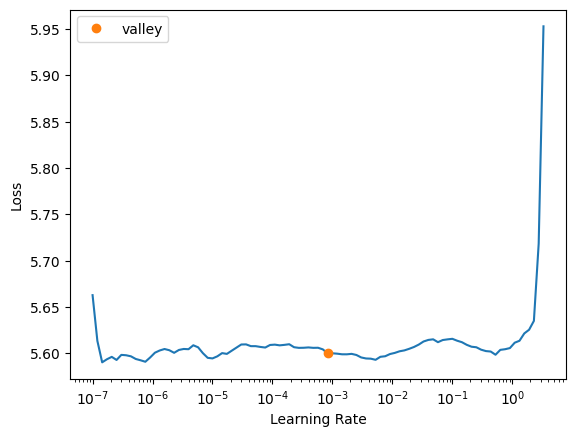

In [ ]:
# LEARNING RATE
model = build_ts_model(InceptionTimePlus, dls=dls, depth=9, nf=64, fc_dropout=0, conv_dropout=0)  
learni = Learner(dls, model, metrics=accuracy)
learni = ts_learner(dls, arch=InceptionTimePlus, metrics=accuracy) # == ts_learner(dls, arch=InceptionTimePlus, metrics=accuracy) since InceptionTimePlus is the default arch
learni.lr_find()



In [ ]:
# early stop https://docs.fast.ai/callback.tracker.html 
print("start frames:", FRAMES_OUT, "components", PCA_COMPONENTS)
EPOCHS=80
learni = ts_learner(dls, metrics=accuracy, cbs=[ShowGraph(), EarlyStoppingCallback(monitor='accuracy', patience=4)])
#learni = ts_learner(dls, metrics=accuracy, cbs=ShowGraph())
learni.fit_one_cycle(EPOCHS, lr_max=10e-4)

#SAVE PROB/PRED
probasi, _, predsi = learni.get_X_preds(X[splits[1]])

with open(f"{MODEL_DIR}/prob_incept.pkl", 'wb') as f3:
       pickle.dump(probasi,f3)

pred_list['incept'] = predsi
with open(f"{MODEL_DIR}/pred_tsai.pkl", 'wb') as f4:
       pickle.dump(pred_list,f4)

## SAVE MODEL
PATH = f"{MODEL_DIR}/model_incept{FRAMES_OUT}.pkl"
torch.save(learni.model, PATH)

PATH = f"{MODEL_DIR}/model_incept{FRAMES_OUT}.sd"
torch.save(learni.model.state_dict(), PATH)



32FRAME INPUT


In [ ]:
by 120 pca 96 frames lr_max=10e-4)
38	0.447007	1.143655	0.735464	00:26
39	0.405458	1.121130	0.743579	00:25
40	0.400072	1.146967	0.744143	00:26


 by 90 pca  64 fram=mes
33	0.213598	1.270179	0.732360	00:44
34	0.195661	1.278226	0.732501	00:44
35	0.182533	1.282060	0.731019	00:44




64 FRAMES TENSOR FEAT GEN
32	0.308407	1.187585	0.737017	02:51
33	0.286050	1.194081	0.733841	02:51
34	0.285561	1.205711	0.734406	02:51

32 FRAME TENSOR FEAT GETN
32	0.292746	1.313657	0.723680	00:45
33	0.239469	1.313424	0.722622	00:45
34	0.228079	1.313393	0.724104	00:45


64-FRAMES/PCI60
33	0.295558	1.188239	0.737793	02:46
34	0.298747	1.187957	0.736593	02:46
35	0.284587	1.195939	0.734970	02:46

32-FRAMES/PCI60 early
22	0.630780	1.188958	0.718106	00:43
23	0.605225	1.214742	0.713731	00:43
24	0.558536	1.216527	0.715072	00:43

30	0.321596	1.295961	0.716765	00:43
31	0.298942	1.304625	0.717683	00:43


# Inception Inference

In [ ]:
# SAVE PYTORCH MODELS
# Try Model with both Feature Gen and Model

class AModel(nn.Module):
    def __init__(self):
        super(AModel, self).__init__()
        
        self.InputFormat = FeatureGen()
        PATH = f"{MODEL_DIR}/model_incept{FRAMES_OUT}.pkl"
        model = torch.load(PATH) #learni.model  #learni.get_X_preds 
        self.InferModel = model.cpu()
        #self.InferModel.eval()
    
    def forward(self, x):
        x = self.InputFormat(x)
        # if len(x.shape) < 3:
        #   x = np.expand_dims(x, axis=0)
        # x = x.reshape(x.shape[0], x.shape[1], -1)
        # x = np.swapaxes(x,2,1)
        #x = np.nan_to_num(x, copy=False)


        print(x.shape)
        pred = self.InferModel(torch.tensor(x).cpu().float())
        return pred



label_map = json.load(open(f"{BASE_DIR}/sign_to_prediction_index_map.json", "r"))
df = pd.read_csv(TRAIN_FILE)
df['label'] = df['sign'].map(label_map)
df.shape

(94477, 5)

In [ ]:
d = df[2000:2001]   #2000, 2001
print(d['path'])
mod = AModel()
x = load_relevant_data_subset(os.path.join(BASE_DIR, d['path'].item()))
print("Main", x.shape)
pred = mod(x)

print("pred", type(pred))

print("truth:", d.label, d.sign, "prediction=", np.argmax(pred[0].detach().numpy()))


2000    train_landmark_files/28656/1082593511.parquet
Name: path, dtype: object
/content/drive/MyDrive/GaggleSignLang/models


KeyboardInterrupt: ignored

# Transformers

In [ ]:
print(dls.vars)
print(dls.c)
print(dls.len)

120
250
96


SuggestedLRs(valley=1.9054607491852948e-06)

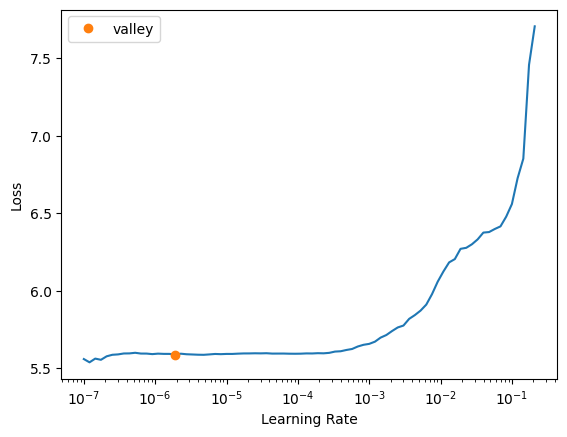

In [ ]:
model = TSTPlus(dls.vars, dls.c, dls.len, dropout=0.3)
# learnt = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAucBinary(), accuracy],  cbs=ShowGraphCallback2())
learnt = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[accuracy],  cbs=ShowGraphCallback2())
learnt.lr_find()


epoch,train_loss,valid_loss,accuracy,time
0,5.561575,5.499636,0.008679,00:51
1,5.492785,5.434957,0.015241,00:52
2,5.348925,5.301733,0.019898,00:52
3,5.186657,5.136842,0.031682,00:52
4,4.888726,4.796987,0.066751,00:53
5,4.562415,4.419488,0.116638,00:53
6,4.247965,4.092632,0.176969,00:53
7,3.919938,3.811691,0.238428,00:53
8,3.657930,3.509048,0.305673,00:53
9,3.361621,3.275306,0.362052,00:53


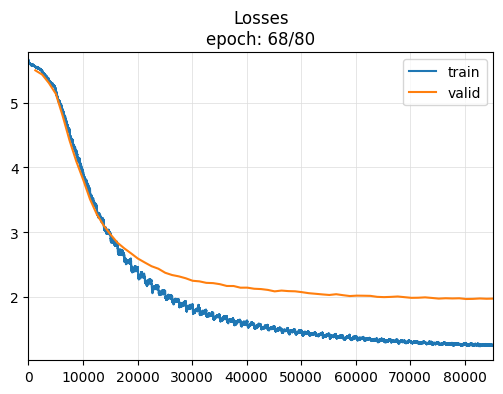

No improvement since epoch 64: early stopping


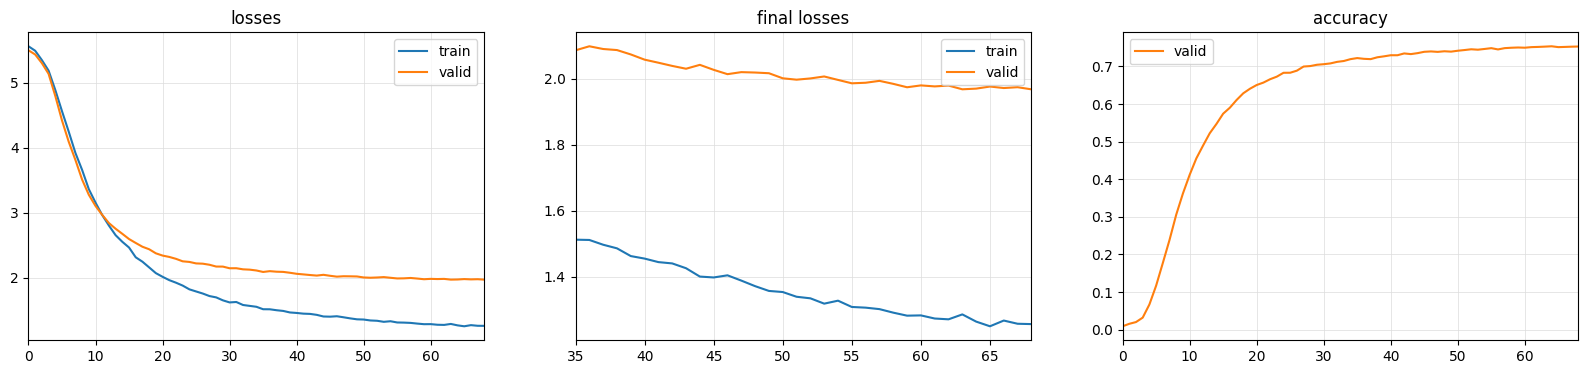


Elapsed time: 3939.8430507183075


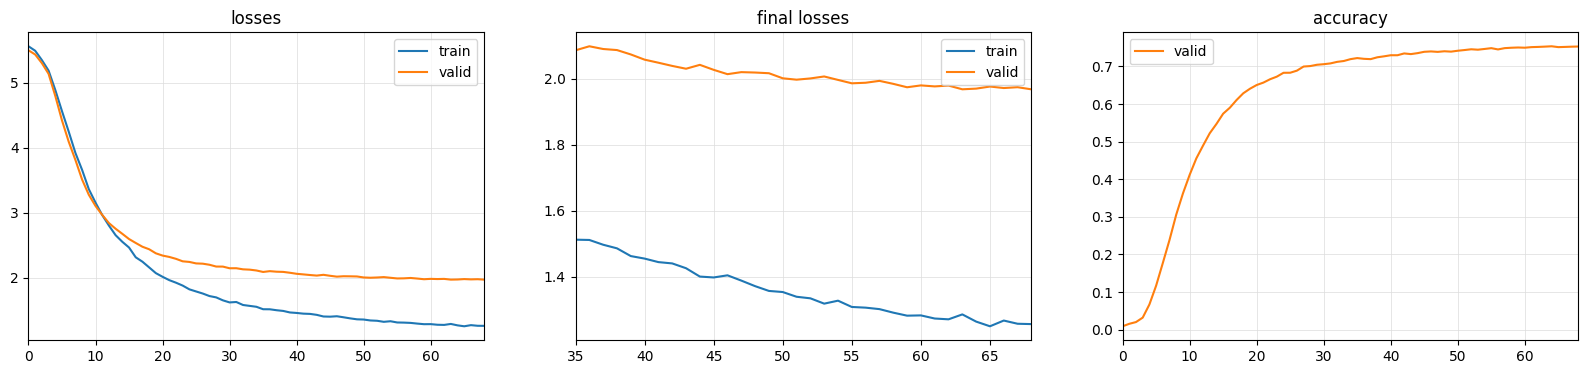

In [ ]:
EPOCHS = 80
# num_layers: the number of sub-encoder-layers in the encoder. Usual values: 2-8. Default: 3.
# n_heads: parallel attention heads. Usual values: 8-16. Default: 16.
# dropout=0-0.3. Default: 0.1, fc_dropout=0-0.8. Default: 0

model = TST(dls.vars, dls.c, dls.len, dropout=0.3, fc_dropout=0.3,n_layers=8)  
#learnt = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAucBinary(), accuracy],  cbs=ShowGraphCallback2())
learnt = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[accuracy],  cbs=[ShowGraph(), EarlyStoppingCallback(monitor='accuracy', patience=4)])
start = time.time()
learnt.fit_one_cycle(EPOCHS, lr_max=10e-5)
print('\nElapsed time:', time.time() - start)
learnt.plot_metrics()


#EXPORT TRANSFORMER PROB
probast, _, predst = learnt.get_X_preds(X[splits[1]])

with open(f"{MODEL_DIR}/prob_trans.pkl", 'wb') as f3:
       pickle.dump(probast,f3)

pred_list['trans'] = predst
with open(f"{MODEL_DIR}/pred_tsai.pkl", 'wb') as f4:
       pickle.dump(pred_list,f4)

## SAVE MODEL
PATH = f"{MODEL_DIR}/model_trans{FRAMES_OUT}.pkl"
torch.save(learnt.model, PATH)

PATH = f"{MODEL_DIR}/model_trans{FRAMES_OUT}.sd"
torch.save(learnt.model.state_dict(), PATH)



In [ ]:
# Prior Standaraiztion, lr_max=1e-4
early stop, patienc =4
65	1.250116	1.976809	0.751552	00:54
66	1.267466	1.972263	0.752117	00:54
67	1.257764	1.974775	0.752752	00:54
68	1.256714	1.968299	0.753175	00:54







POST TENSOR
by 120 pca 96 frames lr_max=10e-4
77	1.237907	1.976013	0.750212	00:53
78	1.233775	1.985489	0.751200	00:52
79	1.234290	1.984748	0.749718	00:53



64 frames / 90 components
69	1.323481	2.003317	0.740192	00:52
70	1.315709	2.013068	0.741250	00:51
71	1.327270	2.007962	0.739416	00:51




32 FRAMES TENSOR
50	1.604220	2.017758	0.733912	00:56
51	1.615538	2.019021	0.735111	00:56
52	1.604192	2.021329	0.734618	00:56

64 FRAMES  TENSOR
55	1.458071	2.106942	0.717824	00:54
56	1.441729	2.108713	0.716483	00:54
57	1.443853	2.103029	0.717189	00:54
..44	1.518437	2.116427	0.713167	00:53
45	1.503531	2.115704	0.712179	00:53
46	1.495585	2.114019	0.713026	00:52

PRE-TENSO
64 FRAMES
45	1.524049	2.136540	0.705899	00:51
46	1.514906	2.132602	0.706746	00:51
47	1.500723	2.126128	0.706393	00:51

32 FRAMES
54	1.481889	2.121107	0.716413	00:53
55	1.478437	2.122445	0.717894	00:53

32 FRAMES
44	1.663647	2.050606	0.723187	00:53
45	1.666268	2.055164	0.723751	00:53

# Try Conversion

In [ ]:
!pip install tensorflow --quiet --root-user-action=ignore
!pip install tensorflow_probability --quiet --root-user-action=ignore

!pip install onnx-tf --quiet --root-user-action=ignore
!pip install tflite-runtime  --quiet --root-user-action=ignore
import onnx_tf
import tflite_runtime
import onnx
from onnx_tf.backend import prepare
import tensorflow as tf

2023-04-29 21:27:18.283232: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
## TSAI MODEL CONVERSION
# pmodel_path = f"{ARCHIVE_DIR}/models/modelccn16flat.sd"
# modelc = ASLModel(.1)
# modelc.load_state_dict(torch.load(py_model_path))
# modelc.eval()

#EXPORT MODEL
PATH = f"{ARCHIVE_DIR}/models/modelIncept.pkl"
learnia = load_learner(PATH)


sample_input = torch.rand((50, 60, 32))
onnx_mod_tsai_path = f"{MODEL_DIR}/model_tsai.onnx"

torch.onnx.export(
    learnia.model,                    # PyTorch Model
    sample_input,                    # Input tensor
    onnx_mod_tsai_path,        # Output file (eg. 'output_model.onnx')
    opset_version=12,         # Operator support version
    input_names=['input'],     # Input tensor name (arbitary)
    output_names=['output'], # Output tensor name (arbitary)
    dynamic_axes={'input' : {0: 'input'}
    }
)
onnx_mod_tsai_gen = onnx.load(onnx_mod_tsai_path)
tf_rep = prepare(onnx_mod_tsai_gen)

tf_mod_tsai_path = 'f"{MODEL_DIR}/tf_mod_tsai'
tf_rep.export_graph(tf_mod_tsai_path)



================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



2023-04-29 21:27:35.017849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor '1278' with dtype float and shape [32,32,39]
	 [[{{node 1278}}]]


INFO:tensorflow:Assets written to: f"{MODEL_DIR}/tf_mod_tsai/assets


2023-04-29 21:27:36.988278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'serving_default_input' with dtype float and shape [?,60,32]
	 [[{{node serving_default_input}}]]
INFO:tensorflow:Assets written to: f"{MODEL_DIR}/tf_mod_tsai/assets
